<a href="https://colab.research.google.com/github/Artemiy2708/-/blob/main/Kopie_von_sample_coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 0. Exchange Agent (Stock Market)

In [ ]:
class StockMarket:
  def __init__(self):
    orderBook = pd.DataFrame(list(zip([], [])), columns=['Assets', 'Price', 'Agent', 'AgentID'])
    JesusCreation = [1000, 300.00, '', -1]
    orderBook = orderBook.append(pd.Series(JesusCreation, index=orderBook.columns), ignore_index=True)
    for _ in range(1000):
      randomPrice, randomAssets = np.random.normal(300, 5000), np.ceil(np.random.normal(1000, 64))
      list_ = [randomAssets, randomPrice, '', -1]
      orderBook = orderBook.append(pd.Series(list_, index=orderBook.columns), ignore_index=True)
    orderBook = orderBook[orderBook['Price'] > 0]
    orderBook = orderBook.sort_values(by=['Price'], ascending=False)
    orderBook = orderBook.reset_index()
    orderBook = orderBook.drop(['index'], axis=1)
    medianIndex = int(np.ceil(len(orderBook) / 2))
    self.dfAsk, self.dfBid = orderBook.iloc[:medianIndex, :], orderBook.iloc[medianIndex:, :]
  
  def updBuyMarketOrder(self, quantity, agentName, agentid):
    difference = 0
    quantity = np.float64(quantity)
    bestAskPrice, bestAskAssets = self.dfAsk.iloc[-1]['Price'], self.dfAsk.iloc[-1]['Assets']
    if quantity < bestAskAssets:
      res = np.float64(bestAskAssets - quantity)
      self.dfAsk.iloc[-1]['Assets'] = self.dfAsk.iloc[-1]['Assets'] - quantity
    else:
      while quantity > 0:
        quantity -= bestAskAssets
        self.dfAsk.drop(index=self.dfAsk.index[-1], axis=0, inplace=True)
        self.dfAsk = self.dfAsk.reset_index()
        self.dfAsk = self.dfAsk.drop(['index'], axis=1)
        bestAskAssets = self.dfAsk.iloc[-1]['Assets']
    self.dfAsk = self.dfAsk.sort_values(by=['Price'], ascending=False)
    self.dfAsk = self.dfAsk.reset_index()
    self.dfAsk = self.dfAsk.drop(['index'], axis=1)

  def updSellMarketOrder(self, quantity, agentName, agentid):
    difference = 0
    quantity = np.float64(quantity)
    bestBidPrice, bestBidAssets = self.dfBid.iloc[0]['Price'], self.dfBid.iloc[0]['Assets']
    if quantity < bestBidAssets:
      res = np.float64(bestBidAssets - quantity)
      self.dfBid.at[0, 'Assets'] = res
    else:
      while quantity > 0:
        quantity -= bestBidAssets
        self.dfBid.drop(index=self.dfBid.index[0], axis=0, inplace=True)
        self.dfBid = self.dfBid.reset_index()
        self.dfBid = self.dfBid.drop(['index'], axis=1)
        bestBidAssets = self.dfBid.iloc[0]['Assets']
    self.dfBid = self.dfBid.sort_values(by=['Price'], ascending=False)
    self.dfBid = self.dfBid.reset_index()
    self.dfBid = self.dfBid.drop(['index'], axis=1)
    
  def updBuyLimitOrder(self, price, quantity, agentName, agentid):
    self.dfBid = self.dfBid.append(pd.Series([quantity, price, agentName, agentid], index=self.dfBid.columns), ignore_index=True)
    self.dfBid = self.dfBid.sort_values(by=['Price'], ascending=False)
    self.dfBid = self.dfBid.reset_index()
    self.dfBid = self.dfBid.drop(['index'], axis=1)

  def updSellLimitOrder(self, price, quantity, agentName, agentid):
    self.dfAsk = self.dfAsk.append(pd.Series([quantity, price, agentName, agentid], index=self.dfAsk.columns), ignore_index=True)
    self.dfAsk = self.dfAsk.sort_values(by=['Price'], ascending=False)
    self.dfAsk = self.dfAsk.reset_index()
    self.dfAsk = self.dfAsk.drop(['index'], axis=1)

  def updCancelBuyLimitOrder(self, price, quantity, agentName, agentid):
    to_cancel = self.dfBid[(self.dfBid['Agent'] == agentName) & (self.dfBid['AgentID'] == agentid)].index
    self.dfBid.drop(to_cancel, inplace=True)
    self.dfBid.dropna(inplace=True)
    self.dfBid = self.dfBid.sort_values(by=['Price'], ascending=False)
    self.dfBid = self.dfBid.reset_index()
    self.dfBid = self.dfBid.drop(['index'], axis=1)

  def updCancelSellLimitOrder(self, price, quantity, agentName, agentid):
    to_cancel = self.dfAsk[(self.dfAsk['Agent'] == agentName) & (self.dfAsk['AgentID'] == agentid)].index
    self.dfAsk.drop(to_cancel, inplace=True)
    self.dfAsk.dropna(inplace=True)
    self.dfAsk = self.dfAsk.sort_values(by=['Price'], ascending=False)
    self.dfAsk = self.dfAsk.reset_index()
    self.dfAsk = self.dfAsk.drop(['index'], axis=1)

# 1. Agent-Based Model

In [ ]:
class ZeroIQCounter:
  def __init__(self):
    self.iq0_ID = 0

class MMCounter:
  def __init__(self):
    self.MM_ID = 0

## 1.1 Zero Intelligence Agent

In [ ]:
def lognormal_params(mean, std):
  sigma = np.sqrt(np.log(std ** 2 + 1))
  mu = np.log(mean + 0.000001) - sigma ** 2 / 2
  return mu, sigma

class ZeroIntelligenceAgent:
  def __init__(self, counter, price_std, quantity_mean, quantity_std, orderbook):
    self.Lambda = 1 / price_std
    self.mu, self.sigma = lognormal_params(quantity_mean, quantity_std)
    self.orderbook = orderbook
    self.id = counter
    self.agentName = '0IQ'
    self.recentlyTraded = 0
    self.ordertype = ''
  
  def determinePrice(self, orderType, bidRequest, askRequest):
    value = float('NaN')
    while np.isnan(value):
      rs = random.random()
      if rs < 0.35:
        value = random.uniform(bidRequest, askRequest)
      else:
        delta = random.expovariate(self.Lambda)
        if orderType == 'bid':
          value = bidRequest - delta
        if orderType == 'ask':
          value = askRequest + delta
      if orderType == 'bid':
        if value > self.orderbook.dfAsk.iloc[-1]['Price']:
          value = self.orderbook.dfAsk.iloc[-1]['Price'] * random.uniform(0.001, 0.699)
      if orderType == 'ask':
        if value < self.orderbook.dfBid.iloc[0]['Price']:
          value = self.orderbook.dfBid.iloc[0]['Price'] * random.uniform(1.501, 1.999)
    return value

  def determineQuantity(self):
    value = float('NaN')
    while np.isnan(value):
      value = np.ceil(random.lognormvariate(self.mu, self.sigma))
    return value
  
  def trade(self, bidRequest, askRequest):
    if not bidRequest or not askRequest:
      return 0
    rs0, rs1, orderType = random.random(), random.random(), ''
    if rs0 > 0.5:
      orderType = 'bid'
      self.ordertype = 'bid'
    else:
      orderType = 'ask'
      self.ordertype = 'ask'
    if rs1 > 0.85:  # execute market order
      quantity = self.determineQuantity()
      if orderType == 'bid':
        self.orderbook.updBuyMarketOrder(quantity, self.agentName, self.id)
        self.recentlyTraded = quantity
      if orderType == 'ask':
        self.orderbook.updSellMarketOrder(quantity, self.agentName, self.id)
        self.recentlyTraded = quantity
    elif rs1 > 0.5: # execute limit order
      price, quantity = self.determinePrice(orderType, bidRequest, askRequest), self.determineQuantity()
      if orderType == 'bid':
        self.orderbook.updBuyLimitOrder(price, quantity, self.agentName, self.id)
      if orderType == 'ask':
        self.orderbook.updSellLimitOrder(price, quantity, self.agentName, self.id)
      else:
        return 0
    elif rs1 <= 0.5:  # order cancellation
      self.orderbook.updCancelBuyLimitOrder(0, 0, self.agentName, self.id)
      self.orderbook.updCancelSellLimitOrder(0, 0, self.agentName, self.id)
    return 0

## 1.2 Market Maker

In [ ]:
class MarketMaker:
  def __init__(self, counter, cash, inventory, uniformLow, uniformHigh,orderbook, UL=2*10**4, LL=-2*10**4):
    self.cash, self.inventory = cash, inventory
    self.UL, self.LL = UL, LL
    self.uniformLow, self.uniformHigh = uniformLow, uniformHigh
    self.tradingVolume, self.state = [0.0, 0.0], 'normal'
    self.orderbook = orderbook
    self.agentName = 'MM'
    self.id = counter
    self.recentlyTraded = 0

  def getBidVolume(self):
    bid_volume = float('NaN')
    while np.isnan(bid_volume):
      bid_volume = np.ceil(max(0.0, (self.UL - 1 - self.inventory)) * np.random.uniform(self.uniformLow, self.uniformHigh))
    return bid_volume

  def getAskVolume(self):
    ask_volume = float('NaN')
    while np.isnan(ask_volume):
      ask_volume = np.ceil(max(0.0, (self.inventory - self.LL - 1)) * np.random.uniform(self.uniformLow, self.uniformHigh))
    return ask_volume

  def trade(self, askRequest, bidRequest):
    if self.inventory < self.LL or self.inventory > self.UL:
      self.state = 'panic'
    if self.LL <= self.inventory <= self.UL:
      self.state = 'normal'
    if self.state == 'normal':
      bidVolume, askVolume = self.getBidVolume(), self.getAskVolume()
      self.tradingVolume[0], self.tradingVolume[1] = bidVolume, askVolume
      self.inventory = self.inventory + self.tradingVolume[0] - self.tradingVolume[1]
      self.clearAllPreviousOrders()
      self.orderbook.updBuyLimitOrder(bidRequest - ((askRequest - bidRequest) * (self.inventory / self.UL)), bidVolume, self.agentName, self.id)
      self.orderbook.updSellLimitOrder(askRequest + ((askRequest - bidRequest) * (self.inventory / self.UL)), askVolume, self.agentName, self.id)
      self.recentlyTraded = 0
    elif self.state == 'panic':
      if self.inventory < self.LL:
        to_buy = abs(0 - self.inventory)
        self.orderbook.updBuyMarketOrder(to_buy, self.agentName, self.id)
        self.inventory = 0
        self.state = 'normal'
        self.recentlyTraded = to_buy
      if self.inventory > self.UL:
        to_sell = abs(0 - self.inventory)
        self.orderbook.updCancelSellLimitOrder(to_sell, self.agentName, self.id)
        self.state = 'normal'
        self.recentlyTraded = to_sell
      return 0

  def clearAllPreviousOrders(self):
    self.orderbook.updCancelBuyLimitOrder(0, 0, self.agentName, self.id)
    self.orderbook.updCancelSellLimitOrder(0, 0, self.agentName, self.id)
    self.tradingVolume = [0.0, 0.0]

# 2. Simulator

## 2.1 Implementation

In [ ]:
class Simulator:
  # '''
  # --> We assume that an HFT market-maker will operate a long-short strategy.
  # --> We make the simplifying assumption that decisions are made in discrete time and
  #     that at each time step the HFT cancels all previous orders and issues a new set of orders to the exchange.
  # --> We assume there is only one exchange, and the HFT is trading in only one market.
  # --> We assume that the HFTs are not engaging in any other activity and therefore only gain
  #     inventory if their Bids are hit or Buys are filled, and only lose inventory if their Offers are hit or their Sells are filled.
  # ========================
  # TO PLOT:
  #   ■ price at each iteration;
  #   ■ all the available volume;
  #   ■ price volatility at each iteration;
  #   ■ investigate the panic situations
  # ========================
  # time axis: [[0], [1], [2], [3], [4], ..., [n - 1], [n]]
  # [0]:
  #   all the traders make their decisions and, if possible, edit the order book with their decisions
  # [1]:
  #   all the traders make their decisions and, if possible, edit the order book with their decisions
  # ...
  # and so on till [n].
  # '''
  def __init__(self, N, team0iq, teamMM,orderbook, state=0, delay=0):
    # state: 0 - a normal simulator, 1 - information shock, 2 - transcation cost, 3 - rapid change in price
    self.mu = ORDERBOOK.dfAsk.iloc[-1]['Price']
    self.pricesAtEachIteration = []
    self.bidPricesAtEachIteration = []
    self.volumesAtEachIteration = []
    self.priceVolatilityatEachIteration = []
    self.isPanic = []
    self.proceedingTime = N
    self.team0iq = team0iq
    self.teamMM = teamMM
    self.orderbook = orderbook
    self.delay = delay
    self.state = state
    for k in range(len(self.teamMM)):
      self.isPanic.append([])
      for h in range(N):
        self.isPanic[k].append(False)
    
  def simulate(self): # launches if no shocks are given
    for i in range(self.proceedingTime):
      if i % 5 == 0:
        self.state = int(input())
        self.delay = int(input())
      if self.state == 0:
        volume = 0
        self.pricesAtEachIteration.append(self.orderbook.dfAsk.iloc[-1]['Price'])
        self.priceVolatilityatEachIteration.append(np.sqrt(1 / (len(self.orderbook.dfAsk) +
                                                                len(self.orderbook.dfBid)) *
                                                            ((self.orderbook.dfAsk.iloc[-1]['Price'] - self.mu)**2 +
                                                            (self.orderbook.dfBid.iloc[0]['Price'] - self.mu)**2)))
        for j in range(0, len(self.team0iq)):
          bid_, ask_ = np.random.normal(0.75 * self.mu, 32), np.random.normal(1.25 * self.mu, 32)
          bid = min(bid_, ask_)
          ask = max(bid_, ask_)
          self.team0iq[j].trade(bid, ask)
          volume += self.team0iq[j].recentlyTraded
        for j in range(0, len(self.teamMM)):
          if self.teamMM[j].inventory < self.teamMM[j].LL or self.teamMM[j].inventory > self.teamMM[j].UL:
            self.isPanic[j][i] = True
          elif self.teamMM[j].LL <= self.teamMM[j].inventory <= self.teamMM[j].UL:
            self.isPanic[j][i] = False
          self.teamMM[j].trade(self.orderbook.dfAsk.iloc[-1]['Price'], self.orderbook.dfBid.iloc[0]['Price'])
          volume += self.teamMM[j].recentlyTraded
        self.volumesAtEachIteration.append(volume)
        self.bidPricesAtEachIteration.append(self.orderbook.dfBid.iloc[0]['Price'])
      elif self.state == 1: # launches if there is an information shock (time delay)
        volume = 0
        self.pricesAtEachIteration.append(self.orderbook.dfAsk.iloc[-1]['Price'])
        self.priceVolatilityatEachIteration.append(np.sqrt(1 / (len(self.orderbook.dfAsk) +
                                                                len(self.orderbook.dfBid)) *
                                                            ((self.orderbook.dfAsk.iloc[-1]['Price'] - self.mu)**2 +
                                                            (self.orderbook.dfBid.iloc[0]['Price'] - self.mu)**2)))
        for j in range(0, len(self.team0iq)):
          bid_, ask_ = np.random.normal(0.75 * self.mu, 32), np.random.normal(1.25 * self.mu, 32)
          bid = min(bid_, ask_)
          ask = max(bid_, ask_)
          self.team0iq[j].trade(bid, ask)
          volume += self.team0iq[j].recentlyTraded
        for j in range(0, len(self.teamMM)):
          if self.teamMM[j].inventory < self.teamMM[j].LL or self.teamMM[j].inventory > self.teamMM[j].UL:
            self.isPanic[j][i] = True
          elif self.teamMM[j].LL <= self.teamMM[j].inventory <= self.teamMM[j].UL:
            self.isPanic[j][i] = False
          self.teamMM[j].trade(self.pricesAtEachIteration[-self.delay], self.bidPricesAtEachIteration[-self.delay])
          volume += self.teamMM[j].recentlyTraded
        self.volumesAtEachIteration.append(volume)
        self.bidPricesAtEachIteration.append(self.orderbook.dfBid.iloc[0]['Price'])
      elif self.state == 2:
        orderBook = pd.DataFrame(list(zip([], [])), columns=['Assets', 'Price', 'Agent', 'AgentID'])
        scenario = random.randrange(1, 3)
        if scenario == 1: # rapid growth of prices
          JesusCreation = [1000, 1000, '', -1]
          orderBook = orderBook.append(pd.Series(JesusCreation, index=orderBook.columns), ignore_index=True)
          for _ in range(1000):
            randomPrice, randomAssets = np.random.normal(1000, 5000), np.ceil(np.random.normal(1000, 64))
            list_ = [randomAssets, randomPrice, '', -1]
            orderBook = orderBook.append(pd.Series(list_, index=orderBook.columns), ignore_index=True)
          orderBook = orderBook[orderBook['Price'] > 0]
          orderBook = orderBook.sort_values(by=['Price'], ascending=False)
          orderBook = orderBook.reset_index()
          orderBook = orderBook.drop(['index'], axis=1)
          medianIndex = int(np.ceil(len(orderBook) / 2))
          self.orderbook.dfAsk, self.orderbook.dfBid = orderBook.iloc[:medianIndex, :], orderBook.iloc[medianIndex:, :]
        else: # rapid decrease in prices
          JesusCreation = [1000, 42, '', -1]
          orderBook = orderBook.append(pd.Series(JesusCreation, index=orderBook.columns), ignore_index=True)
          for _ in range(1000):
            randomPrice, randomAssets = np.random.normal(42, 5000), np.ceil(np.random.normal(1000, 64))
            list_ = [randomAssets, randomPrice, '', -1]
            orderBook = orderBook.append(pd.Series(list_, index=orderBook.columns), ignore_index=True)
          orderBook = orderBook[orderBook['Price'] > 0]
          orderBook = orderBook.sort_values(by=['Price'], ascending=False)
          orderBook = orderBook.reset_index()
          orderBook = orderBook.drop(['index'], axis=1)
          medianIndex = int(np.ceil(len(orderBook) / 2))
          self.orderbook.dfAsk, self.orderbook.dfBid = orderBook.iloc[:medianIndex, :], orderBook.iloc[medianIndex:, :]
        for j in range(0, len(self.team0iq)):
          bid_, ask_ = np.random.normal(0.75 * self.mu, 32), np.random.normal(1.25 * self.mu, 32)
          bid = min(bid_, ask_)
          ask = max(bid_, ask_)
          self.team0iq[j].trade(bid, ask)
          volume += self.team0iq[j].recentlyTraded
        for j in range(0, len(self.teamMM)):
          if self.teamMM[j].inventory < self.teamMM[j].LL or self.teamMM[j].inventory > self.teamMM[j].UL:
            self.isPanic[j][i] = True
          elif self.teamMM[j].LL <= self.teamMM[j].inventory <= self.teamMM[j].UL:
            self.isPanic[j][i] = False
          self.teamMM[j].trade(self.orderbook.dfAsk.iloc[-1]['Price'], self.orderbook.dfBid.iloc[0]['Price'])
          volume += self.teamMM[j].recentlyTraded
        self.volumesAtEachIteration.append(volume)
        self.bidPricesAtEachIteration.append(self.orderbook.dfBid.iloc[0]['Price'])
  
  def plot_price(self):
     plt.plot(np.arange(self.proceedingTime), self.pricesAtEachIteration)
     plt.legend()
     plt.show()
  def plot_volume(self):
     plt.plot(np.arange(self.proceedingTime), self.volumesAtEachIteration)
     plt.legend()
     plt.show()
  def plot_volatility(self):
     plt.plot(np.arange(self.proceedingTime), self.priceVolatilityatEachIteration)
     plt.legend()
     plt.show()
  def plot_bid_ask(self):
     plt.plot(np.arange(self.proceedingTime),self.pricesAtEachIteration)
     plt.plot(np.arange(self.proceedingTime),self.bidPricesAtEachIteration)
     plt.legend()
     plt.show()

  

## 2.2 Execution

In [ ]:
ORDERBOOK = StockMarket()

In [ ]:
iq0_id, MM_id = ZeroIQCounter(), MMCounter()
team0iq = []
teamMM = []
MM_params = [[3000, 0.9, 1.0], [2000, 0.8, 1.0], [2000, 0.8, 1.0]]
for i in range(0, 10):
  team0iq.append(ZeroIntelligenceAgent(iq0_id.iq0_ID, 4.0, 1.0, 1.0,ORDERBOOK))
  iq0_id.iq0_ID += 1
for i in range(0, 3):
  teamMM.append(MarketMaker(MM_id.MM_ID, 10**12, MM_params[i][0], MM_params[i][1], MM_params[i][2],ORDERBOOK))
  MM_id.MM_ID += 1
simulator0 = Simulator(10, team0iq, teamMM,ORDERBOOK)
simulator0.simulate()

0
0
0
0


In [ ]:
simulator0.pricesAtEachIteration

[3448.192808288643,
 3448.168248822513,
 3448.1680319887228,
 3448.1488245103906,
 3448.1487478937624,
 3448.1464385700015,
 3448.143051624418,
 3448.140898501514,
 3448.135766274929,
 3448.135617556233]

In [ ]:
simulator0.priceVolatilityatEachIteration

[0.005091350623365664,
 0.004126306777906215,
 0.004119679509338016,
 0.0036808059306474485,
 0.003659222074802571,
 0.0036349618785017543,
 0.00359557330599136,
 0.0035654821121180063,
 0.003550976970030921,
 0.0035507724465755827]

### 2.3 Illustration of the ABM Stock Market Simulations Without Shocks

No handles with labels found to put in legend.


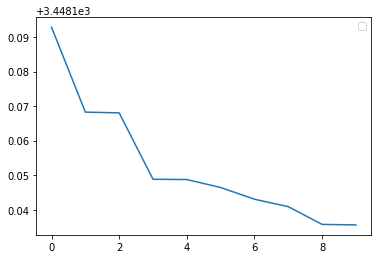

In [ ]:
simulator0.plot_price()

No handles with labels found to put in legend.


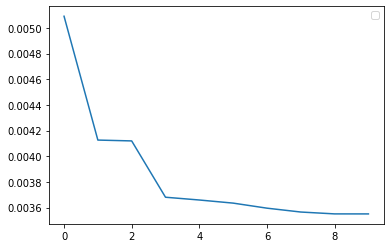

In [ ]:
simulator0.plot_volatility()

No handles with labels found to put in legend.


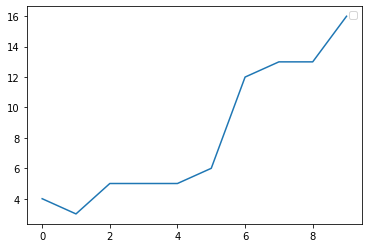

In [ ]:
simulator0.plot_volume()

No handles with labels found to put in legend.


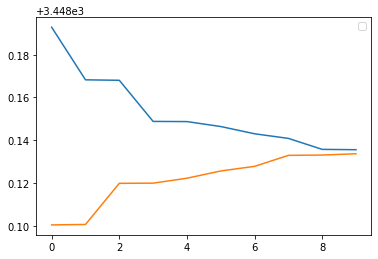

In [ ]:
simulator0.plot_bid_ask()

# 3. Shocks

## 3.1 Information Shock

In [ ]:
ORDERBOOK = StockMarket()

In [ ]:
iq0_id, MM_id = ZeroIQCounter(), MMCounter()
team0iq = []
teamMM = []
MM_params = [[3000, 0.9, 1.0], [2000, 0.8, 1.0], [2000, 0.8, 1.0]]
for i in range(10):
  team0iq.append(ZeroIntelligenceAgent(iq0_id.iq0_ID, 4.0, 1.0, 1.0,ORDERBOOK))
  iq0_id.iq0_ID += 1
for i in range(len(MM_params)):
  teamMM.append(MarketMaker(MM_id.MM_ID, 10**12, MM_params[i][0], MM_params[i][1], MM_params[i][2],ORDERBOOK))
  MM_id.MM_ID += 1
simulator1 = Simulator(20, team0iq, teamMM,ORDERBOOK)
simulator1.simulate()

0
0
1
3
1
5
1
3


In [ ]:
display(simulator1.orderbook.dfAsk)
display(simulator1.orderbook.dfBid)

,Assets,Price,Agent,AgentID
0,1102.0,15764.470550,,-1
1,942.0,14441.307285,,-1
2,970.0,13968.160239,,-1
3,873.0,13965.028880,,-1
4,963.0,13297.380568,,-1
...,...,...,...,...
258,1016.0,3790.485444,,-1
259,995.0,3764.761111,,-1
260,16737.0,3757.417448,MM,2
261,17082.0,3757.139242,MM,1


,Assets,Price,Agent,AgentID
0,19143.0,3755.455002,MM,0
1,16639.0,3755.442871,MM,1
2,19642.0,3755.164665,MM,2
3,924.0,3747.821002,,-1
4,956.0,3735.331042,,-1
...,...,...,...,...
261,1081.0,52.156526,,-1
262,962.0,50.921641,,-1
263,928.0,38.288277,,-1
264,980.0,22.114794,,-1


In [ ]:
simulator1.priceVolatilityatEachIteration

[0.7457467052515238,
 0.5506879326386797,
 0.5575607846825464,
 0.5321786075235322,
 0.5356534689477882,
 0.5218011799784216,
 0.5339743284220775,
 0.522282999977662,
 0.5243097347043265,
 0.5274945979911414,
 0.5280840333834723,
 0.5310883406404084,
 0.5224771097259576,
 0.5204431470007016,
 0.5217732237968626,
 0.521873686796246,
 0.5210248937925772,
 0.5202944691982025,
 0.5249286479906956,
 0.5204823083405061]

In [ ]:
simulator1.pricesAtEachIteration

[3764.7611107820358,
 3759.122102543286,
 3759.4315358861545,
 3758.0307958738326,
 3758.2926266638283,
 3757.0310442574005,
 3758.419453671075,
 3757.458572337151,
 3757.12443072432,
 3757.7517754488404,
 3757.556643675416,
 3757.9827065521636,
 3757.3608512536657,
 3756.845333664922,
 3757.39579821796,
 3757.4084434061,
 3756.7348107793778,
 3757.1896533957406,
 3757.421963788808,
 3756.7183918675414]

No handles with labels found to put in legend.


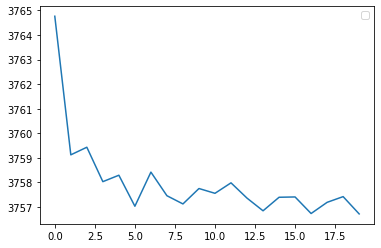

In [ ]:
simulator1.plot_price()

No handles with labels found to put in legend.


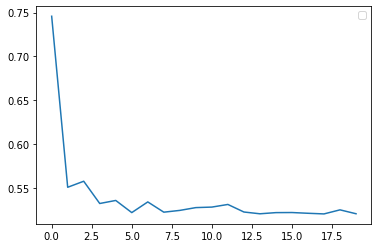

In [ ]:
simulator1.plot_volatility()

No handles with labels found to put in legend.


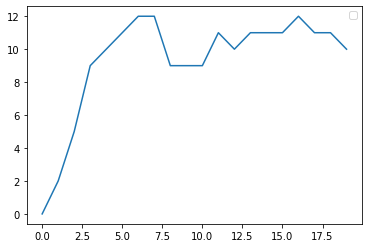

In [ ]:
simulator1.plot_volume()

No handles with labels found to put in legend.


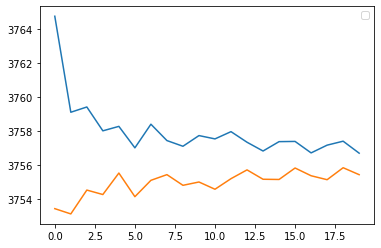

In [ ]:
simulator1.plot_bid_ask()